# Time Bar Analysis

Analysis based on 10s time bars.

In [1]:
import gc
import os
from typing import Dict, List, Tuple

import dask.bag as db
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from scipy import stats

In [2]:
from utils import read_bars as read_bars_internal

In [3]:
TIME_BAR_DIR = '/data/bars/TimeBar'
BAR_SIZE = 10000  # in milliseconds, choices: 10000, 60000, 180000, 300000, 900000, 1800000, 360000

In [4]:
!ls /data/bars/TimeBar

10000  180000  1800000	300000	3600000  60000	900000


In [5]:
# Read bars in May 2020
def read_bars(csv_file: str)->pd.DataFrame:
    TIME_BEGIN = pd.to_datetime(1588291200000, unit='ms')  # 2020-05-01T00:00:00.000Z
    TIME_END = pd.to_datetime(1590969600000, unit='ms')    # 2020-06-01T00:00:00.000Z
    bars_df = read_bars_internal(csv_file)
    bars_df = bars_df[(bars_df['timestamp'] >= TIME_BEGIN) & (bars_df['timestamp_end'] <= TIME_END)]
    return bars_df

In [6]:
BTC_PAIRS = [
    ('Binance', 'Spot', 'BTC_USDT'),
    ('Binance', 'Swap', 'BTC_USDT'),
    ('BitMEX', 'Swap', 'BTC_USD'),
    ('Huobi', 'Spot', 'BTC_USDT'),
    ('Huobi', 'Swap', 'BTC_USD'),
    ('OKEx', 'Spot', 'BTC_USDT'),
    ('OKEx', 'Swap', 'BTC_USDT'),
    ('OKEx', 'Swap', 'BTC_USD'),
]

ETH_PAIRS = [
    ('Binance', 'Spot', 'ETH_USDT'),
    ('Binance', 'Swap', 'ETH_USDT'),
    ('BitMEX', 'Swap', 'ETH_USD'),
    ('Huobi', 'Spot', 'ETH_USDT'),
    ('Huobi', 'Swap', 'ETH_USD'),
    ('OKEx', 'Spot', 'ETH_USDT'),
    ('OKEx', 'Swap', 'ETH_USDT'),
    ('OKEx', 'Swap', 'ETH_USD'),
]

In [7]:
def get_csv_file(exchange: str, market_type: str, pair: str, bar_size: int)->str:
    return os.path.join(TIME_BAR_DIR, str(bar_size), f'TimeBar.{bar_size}.{exchange}.{market_type}.{pair}.csv')

In [8]:
get_csv_file(*BTC_PAIRS[0], 10000)

'/data/bars/TimeBar/10000/TimeBar.10000.Binance.Spot.BTC_USDT.csv'

In [9]:
get_csv_file(*BTC_PAIRS[0], 60000)

'/data/bars/TimeBar/60000/TimeBar.60000.Binance.Spot.BTC_USDT.csv'

In [10]:
read_bars(get_csv_file(*BTC_PAIRS[0], 10000)).head()

,exchange,market_type,pair,bar_type,bar_size,timestamp,timestamp_end,open,high,low,...,median,volume,volume_sell,volume_buy,volume_quote,volume_quote_sell,volume_quote_buy,count,count_sell,count_buy
timestamp,,,,,,,,,,,,,,,,,,,,,
2020-05-01 00:00:00,Binance,Spot,BTC_USDT,TimeBar,10000,2020-05-01 00:00:00,2020-05-01 00:00:10,8620.000000,8621.769531,8613.559570,...,8618.500000,30.714120,23.850420,6.863700,264702.560,205544.330,264678.720,151,97,54
2020-05-01 00:00:10,Binance,Spot,BTC_USDT,TimeBar,10000,2020-05-01 00:00:10,2020-05-01 00:00:20,8618.009766,8620.000000,8615.509766,...,8617.910156,5.218622,4.380178,0.838444,44972.797,37747.914,44968.418,81,63,18
2020-05-01 00:00:20,Binance,Spot,BTC_USDT,TimeBar,10000,2020-05-01 00:00:20,2020-05-01 00:00:30,8618.000000,8625.120117,8618.000000,...,8622.940430,38.962437,30.654339,8.308098,335841.440,264191.970,335810.780,154,88,66
2020-05-01 00:00:30,Binance,Spot,BTC_USDT,TimeBar,10000,2020-05-01 00:00:30,2020-05-01 00:00:40,8624.929688,8635.370117,8622.780273,...,8630.064453,8.409688,4.571589,3.838099,72560.710,39451.477,72556.130,102,61,41
2020-05-01 00:00:40,Binance,Spot,BTC_USDT,TimeBar,10000,2020-05-01 00:00:40,2020-05-01 00:00:50,8633.750000,8642.629883,8631.070312,...,8636.074219,8.470530,6.005441,2.465090,73157.630,51869.600,73151.630,120,78,42


## 1. Ratio of empty bars(bar without trade)

In [11]:
def calc_empty_ratio(bars: pd.DataFrame)->float:
    time_gaps = bars['timestamp'].diff(1).dropna().astype('int64') // int(1e6)
    bar_size = time_gaps.value_counts().idxmax()    
    time_gaps_illegal = time_gaps[time_gaps > bar_size]
    if bar_size < 900000:  # crawer restart timeout is 15 minutes
        time_gaps_illegal = time_gaps_illegal[time_gaps_illegal < 900000]
    
    num_empty_bars = time_gaps_illegal.sum() // bar_size
    empty_ratio = num_empty_bars / time_gaps.size
    return empty_ratio

In [12]:
def calc_empty_ratio_multi(exchange_market_pairs: List[Tuple[str, str, str]], bar_size: int)->pd.DataFrame:
    empty_ratios = []
    for exchange_market_pair in exchange_market_pairs:
        exchange, market_type, pair = exchange_market_pair
        file = get_csv_file(exchange, market_type, pair, bar_size)
        bars_df = read_bars(file)
        empty_ratio = calc_empty_ratio(bars_df)
        del bars_df
        # print(f'{exchange}.{market_type}.{pair}: {empty_ratio:.2%}')
        empty_ratios.append((exchange, market_type, pair, empty_ratio))
    gc.collect()
    df = pd.DataFrame(empty_ratios, columns=['exchange', 'market_type', 'pair', 'empty_ratio'])
    df.sort_values('empty_ratio', inplace=True)
    df['empty_ratio'] = df['empty_ratio'].apply(lambda x: f'{x:.2%}')
    return df

In [13]:
calc_empty_ratio_multi(BTC_PAIRS, BAR_SIZE)

,exchange,market_type,pair,empty_ratio
1,Binance,Swap,BTC_USDT,1.63%
0,Binance,Spot,BTC_USDT,1.64%
3,Huobi,Spot,BTC_USDT,2.17%
2,BitMEX,Swap,BTC_USD,2.43%
5,OKEx,Spot,BTC_USDT,6.26%
4,Huobi,Swap,BTC_USD,10.50%
7,OKEx,Swap,BTC_USD,17.84%
6,OKEx,Swap,BTC_USDT,18.41%


In [14]:
calc_empty_ratio_multi(ETH_PAIRS, BAR_SIZE)

,exchange,market_type,pair,empty_ratio
0,Binance,Spot,ETH_USDT,1.68%
1,Binance,Swap,ETH_USDT,1.74%
3,Huobi,Spot,ETH_USDT,7.51%
5,OKEx,Spot,ETH_USDT,25.72%
4,Huobi,Swap,ETH_USD,27.92%
7,OKEx,Swap,ETH_USD,49.39%
2,BitMEX,Swap,ETH_USD,66.85%
6,OKEx,Swap,ETH_USDT,81.13%


## 2. Trading Volume per Bar

In [15]:
def calc_volumes_multi(exchange_market_pairs: List[Tuple[str, str, str]], bar_size: int, volume_column: str='volume')->pd.DataFrame:
    global_stats = []

    for exchange_market_pair in exchange_market_pairs:
        exchange, market_type, pair = exchange_market_pair
        file = get_csv_file(exchange, market_type, pair, bar_size)
        bars_df = read_bars(file)
        volume_stats = bars_df[volume_column].describe([0.5, 0.75, 0.9, 0.95]).to_dict()
        volume_stats['median'] = volume_stats.pop('50%')  # rename '50%' to 'median'
        del bars_df
        global_stats.append({'exchange': exchange, 'market_type': market_type, 'pair': pair, **volume_stats})
    gc.collect()
    return pd.DataFrame(global_stats)

In [16]:
def plot_hist(exchange_market_pairs: List[Tuple[str, str, str]], bar_size: int, volume_column: str='volume')->None:
    '''Plot histogram of volume_column.'''
    assert len(exchange_market_pairs) == 8

    def read_column(exchange: str, market_type: str, pair: str)->pd.Series:
        file = get_csv_file(exchange, market_type, pair, bar_size)
        bars_df = read_bars(file)
        nums = bars_df[volume_column]

        # remove outliers
        nums = nums[nums.between(nums.quantile(0.05), nums.quantile(0.95))]

        nums.rename(f'{exchange}_{market_type}_{pair}', inplace=True)

        del bars_df
        gc.collect()
        return nums

    nums_arr = db.from_sequence(exchange_market_pairs).map(lambda x: read_column(*x)).compute()
    f, axes = plt.subplots(nrows=4, ncols=2, figsize=(13, 20))
    current_palette = sns.color_palette(palette='bright', n_colors=8)
    for i in range(8):
        sns.distplot( nums_arr[i], kde=False, color=current_palette[i], ax=axes[i//2, i%2])

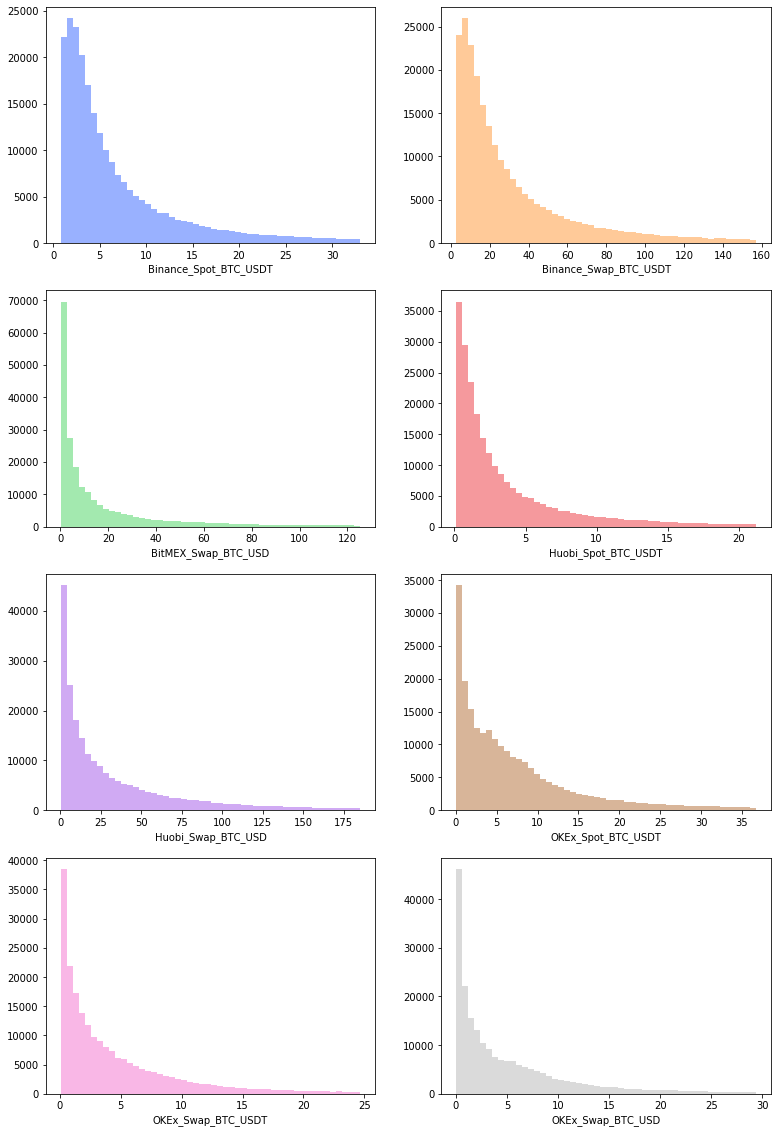

In [17]:
plot_hist(BTC_PAIRS, BAR_SIZE)

In [18]:
calc_volumes_multi(BTC_PAIRS, BAR_SIZE)

,exchange,market_type,pair,count,mean,std,min,75%,90%,95%,max,median
0,Binance,Spot,BTC_USDT,256645.0,9.903305,22.864486,1.394000e-03,9.685767,20.624838,33.054880,1739.6815,4.425461
1,Binance,Swap,BTC_USDT,256783.0,45.877412,104.494129,1.000000e-03,45.602000,98.274000,157.111600,4468.8190,19.895000
2,BitMEX,Swap,BTC_USD,239925.0,29.746280,84.499046,9.998000e-05,24.986320,70.899392,125.480313,4092.6719,6.453123
3,Huobi,Spot,BTC_USDT,255721.0,5.923878,17.340865,2.961972e-07,5.415171,12.719500,21.232645,1376.4031,2.026248
4,Huobi,Swap,BTC_USD,244478.0,49.601141,116.962719,1.999020e-02,51.473057,115.232199,185.264585,4808.0060,17.433374
5,OKEx,Spot,BTC_USDT,250240.0,10.149526,19.778687,9.091500e-04,11.056305,23.277467,36.726672,1563.2675,4.919712
6,OKEx,Swap,BTC_USDT,234235.0,6.797715,16.357765,1.000000e-02,7.040000,14.940000,24.690000,633.5800,2.650000
7,OKEx,Swap,BTC_USD,235508.0,8.207668,22.091097,9.993304e-03,8.105986,17.585367,29.375918,1102.7433,2.891789


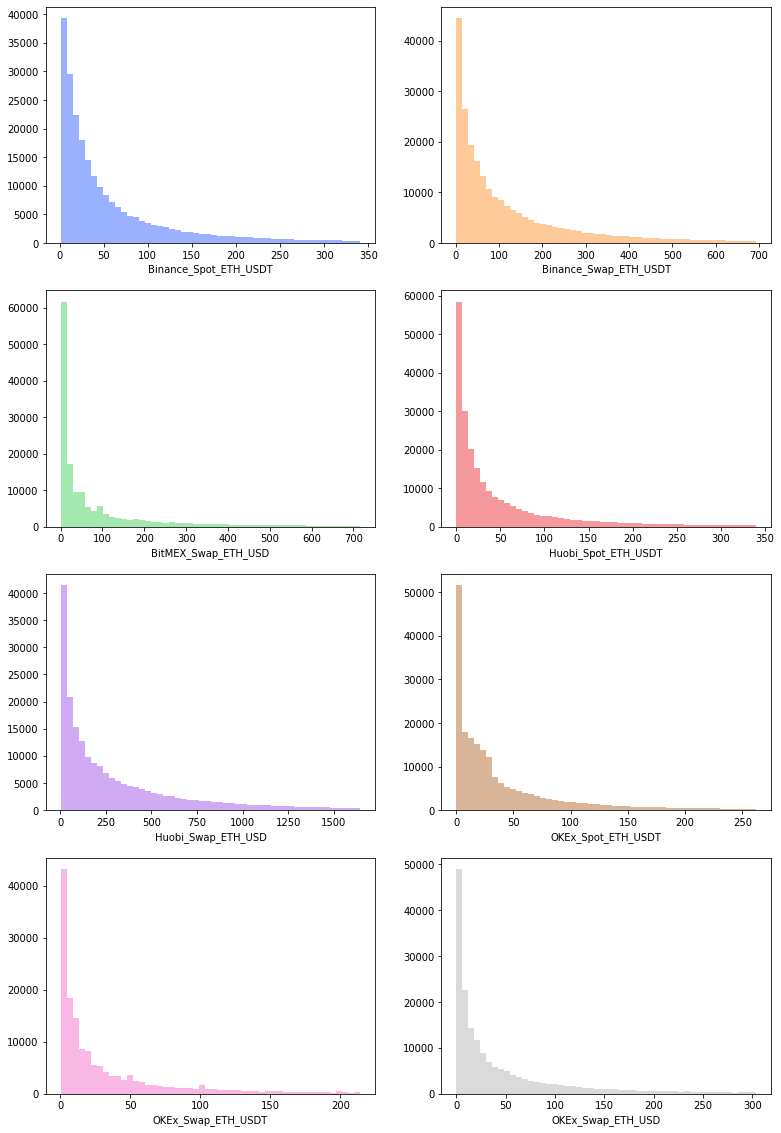

In [19]:
plot_hist(ETH_PAIRS, BAR_SIZE)

In [20]:
calc_volumes_multi(ETH_PAIRS, BAR_SIZE)

,exchange,market_type,pair,count,mean,std,min,75%,90%,95%,max,median
0,Binance,Spot,ETH_USDT,256527.0,91.746025,244.691643,0.000170,85.910387,204.564896,341.095605,15400.4780,31.195730
1,Binance,Swap,ETH_USDT,256632.0,184.347941,438.026972,0.001000,188.747250,429.433700,693.256350,28941.2620,65.780000
2,BitMEX,Swap,ETH_USD,168659.0,160.169172,489.279552,0.008482,121.552440,401.754974,716.678860,26210.7970,25.696453
3,Huobi,Spot,ETH_USDT,249004.0,84.914573,249.510682,0.000034,73.625714,196.380850,339.727967,18286.2340,22.188500
4,Huobi,Swap,ETH_USD,221981.0,443.083858,948.106491,0.082264,488.744300,1067.306400,1646.449200,33575.7420,165.978320
5,OKEx,Spot,ETH_USDT,225578.0,64.354080,160.636241,0.000002,60.413800,148.430771,261.993484,6514.1904,21.101146
6,OKEx,Swap,ETH_USDT,168291.0,50.807710,122.983526,0.100000,49.100000,126.300000,214.300000,3797.5000,13.300000
7,OKEx,Swap,ETH_USD,198689.0,74.348741,185.921101,0.040803,69.817200,182.193802,303.711248,6737.4340,20.044067


## 3. USD Volume per bar

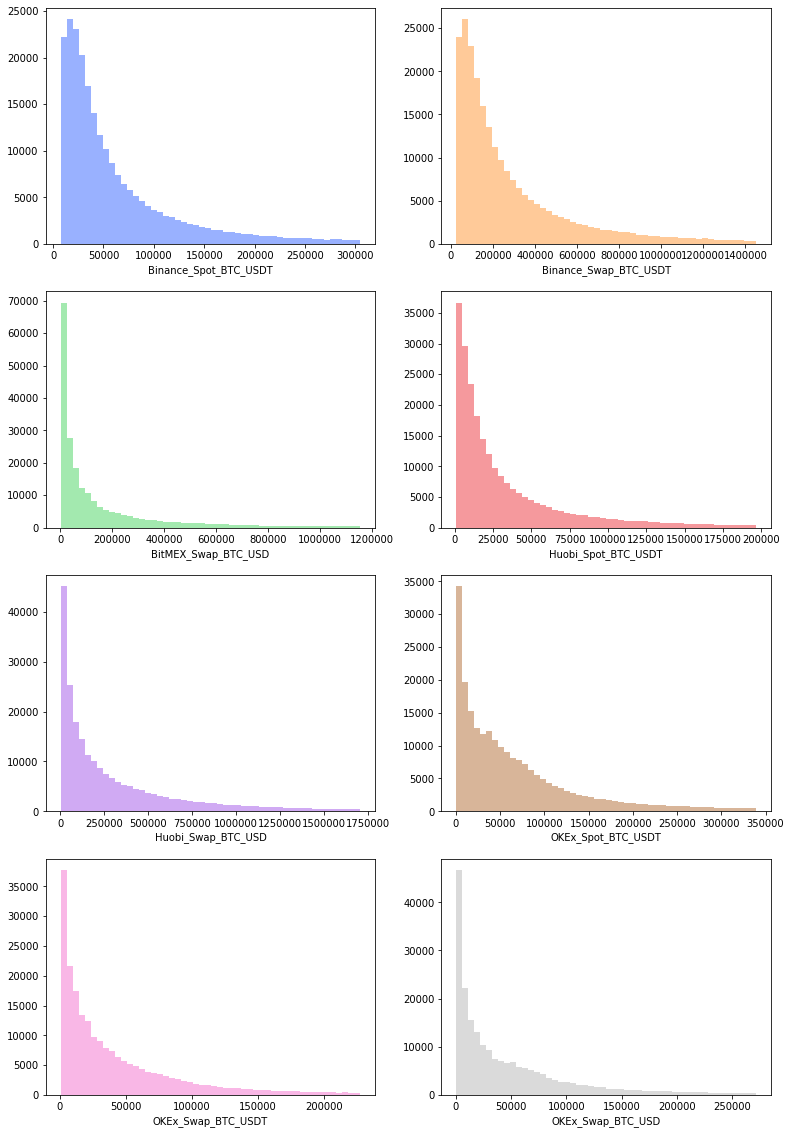

In [21]:
plot_hist(BTC_PAIRS, BAR_SIZE, 'volume_quote')

In [22]:
calc_volumes_multi(BTC_PAIRS, BAR_SIZE, 'volume_quote')

,exchange,market_type,pair,count,mean,std,min,75%,90%,95%,max,median
0,Binance,Spot,BTC_USDT,256645.0,91432.576819,2.113444e+05,13.065962,89393.08600,190339.070,304940.940,16817056.0,40873.9530
1,Binance,Swap,BTC_USDT,256783.0,423269.313226,9.619509e+05,8.921870,420675.75000,907376.188,1450771.470,43470724.0,183440.4400
2,BitMEX,Swap,BTC_USD,239925.0,274215.041849,7.792429e+05,0.999954,230877.80000,654059.060,1155005.240,38535330.0,59680.0400
3,Huobi,Spot,BTC_USDT,255721.0,54755.478614,1.597014e+05,0.002785,50122.68800,117907.020,196609.600,13046056.0,18691.3800
4,Huobi,Swap,BTC_USD,244478.0,456944.734479,1.067450e+06,199.999980,475800.00000,1066000.000,1709460.000,45342800.0,161000.0000
5,OKEx,Spot,BTC_USDT,250240.0,93826.352001,1.833352e+05,8.267537,102106.77875,215258.863,339375.195,14868236.0,45440.5075
6,OKEx,Swap,BTC_USDT,234235.0,62782.117584,1.514726e+05,84.975000,65060.44500,137772.944,227802.812,6105774.0,24495.1000
7,OKEx,Swap,BTC_USD,235508.0,75768.343746,2.041035e+05,99.999990,74900.00000,162500.000,271400.000,10552100.0,26700.0000


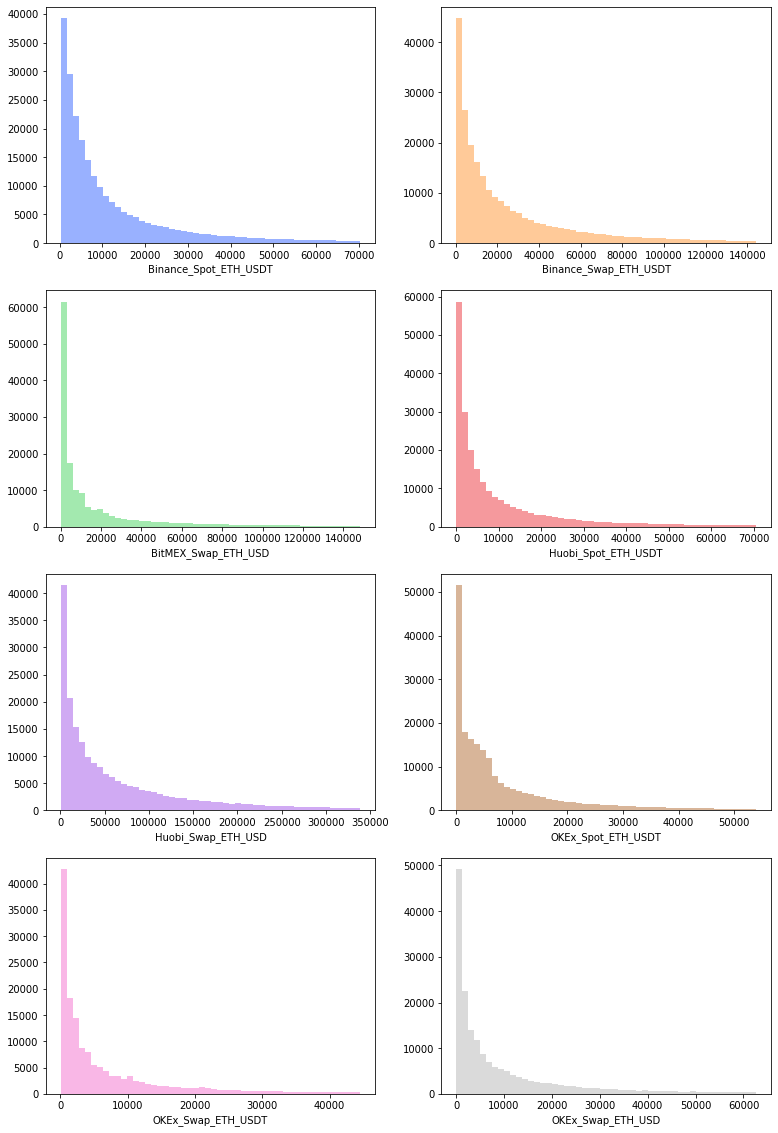

In [23]:
plot_hist(ETH_PAIRS, BAR_SIZE, 'volume_quote')

In [24]:
calc_volumes_multi(ETH_PAIRS, BAR_SIZE, 'volume_quote')

,exchange,market_type,pair,count,mean,std,min,75%,90%,95%,max,median
0,Binance,Spot,ETH_USDT,256527.0,18937.682512,50379.302312,0.034614,17801.99300,42254.5158,70354.9230,3007555.50,6466.39100
1,Binance,Swap,ETH_USDT,256632.0,38194.656597,90583.268268,0.186180,39171.95100,89096.2750,144204.5355,5942503.50,13601.11050
2,BitMEX,Swap,ETH_USD,168659.0,33170.565011,100874.220435,1.544860,25144.91700,83063.1772,148477.6420,4793789.00,5297.58840
3,Huobi,Spot,ETH_USDT,249004.0,17595.321500,51744.844804,0.007361,15263.96575,40701.9980,70515.6290,3701139.00,4587.31590
4,Huobi,Swap,ETH_USD,221981.0,91026.027999,191534.693093,19.999998,101160.00000,220180.0000,338960.0000,6999980.00,34380.00000
5,OKEx,Spot,ETH_USDT,225578.0,13271.365548,32905.658242,0.000405,12515.34125,30819.9770,53934.9289,1362636.10,4370.24285
6,OKEx,Swap,ETH_USDT,168291.0,10537.154134,25622.473985,18.044000,10108.00900,26164.9300,44591.1415,878349.44,2759.31420
7,OKEx,Swap,ETH_USD,198689.0,15315.516608,38005.610055,9.999999,14430.00000,37520.0000,62640.0000,1340360.00,4130.00000


## 4. Number of Trades per bar

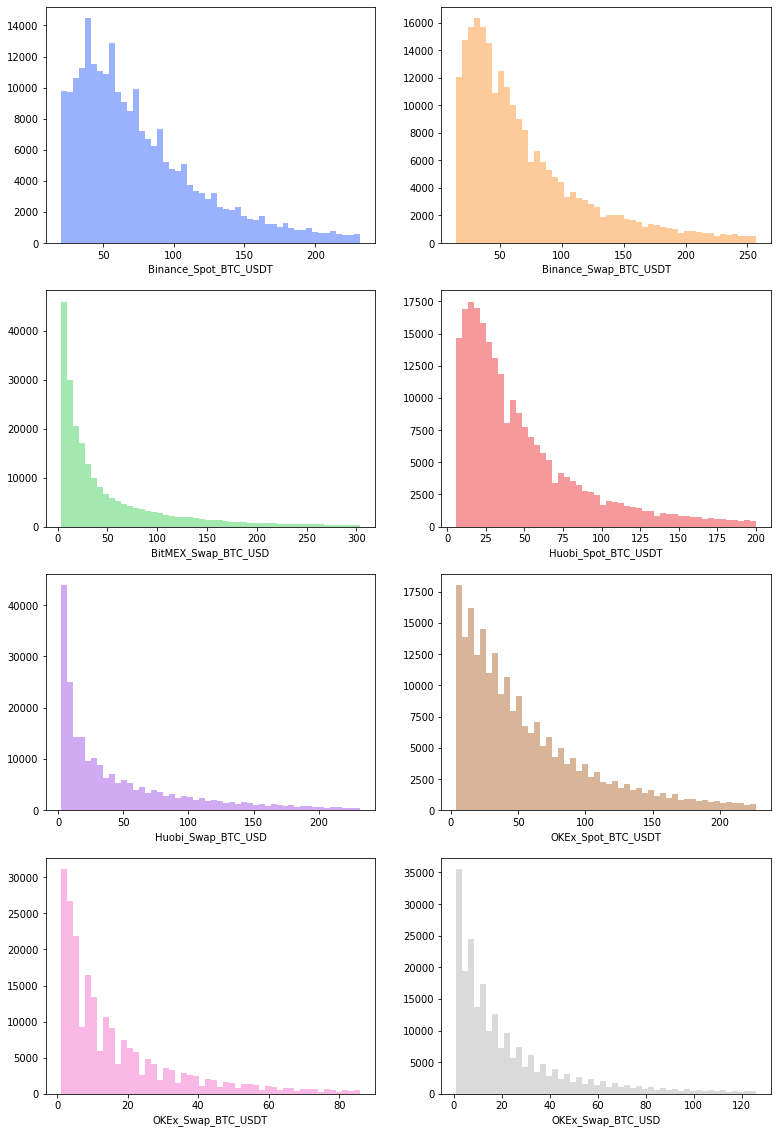

In [25]:
plot_hist(BTC_PAIRS, BAR_SIZE, 'count')

In [26]:
calc_volumes_multi(BTC_PAIRS, BAR_SIZE, 'count')

,exchange,market_type,pair,count,mean,std,min,75%,90%,95%,max,median
0,Binance,Spot,BTC_USDT,256645.0,90.459269,111.368045,1.0,103.0,166.0,232.0,6722.0,64.0
1,Binance,Swap,BTC_USDT,256783.0,89.062041,132.625008,1.0,98.0,176.0,257.0,4410.0,55.0
2,BitMEX,Swap,BTC_USD,239925.0,86.237628,261.640633,1.0,77.0,180.0,304.0,13425.0,27.0
3,Huobi,Spot,BTC_USDT,255721.0,63.269892,102.643761,1.0,70.0,132.0,200.0,5174.0,36.0
4,Huobi,Swap,BTC_USD,244478.0,63.549788,117.539114,1.0,75.0,155.0,232.0,3921.0,26.0
5,OKEx,Spot,BTC_USDT,250240.0,72.060714,106.758123,1.0,86.0,156.0,227.0,3274.0,42.5
6,OKEx,Swap,BTC_USDT,234235.0,24.379947,45.714645,1.0,26.0,55.0,86.0,1656.0,11.0
7,OKEx,Swap,BTC_USD,235508.0,35.671867,78.505891,1.0,36.0,77.0,126.0,2635.0,15.0


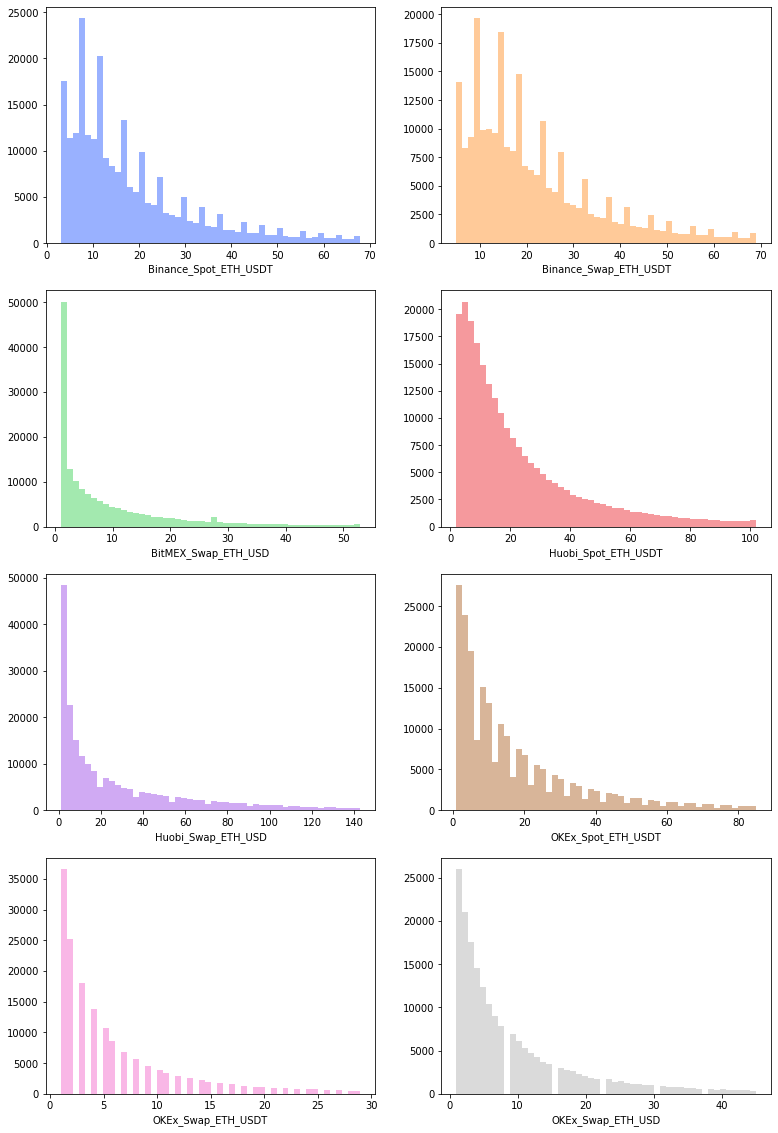

In [27]:
plot_hist(ETH_PAIRS, BAR_SIZE, 'count')

In [28]:
calc_volumes_multi(ETH_PAIRS, BAR_SIZE, 'count')

,exchange,market_type,pair,count,mean,std,min,75%,90%,95%,max,median
0,Binance,Spot,ETH_USDT,256527.0,22.858912,33.601987,1.0,26.0,47.0,68.0,1395.0,14.0
1,Binance,Swap,ETH_USDT,256632.0,25.474586,31.374423,1.0,29.0,49.0,69.0,1252.0,18.0
2,BitMEX,Swap,ETH_USD,168659.0,14.411973,30.225606,1.0,15.0,33.0,53.0,1339.0,6.0
3,Huobi,Spot,ETH_USDT,249004.0,30.676728,56.415775,1.0,34.0,67.0,102.0,1982.0,15.0
4,Huobi,Swap,ETH_USD,221981.0,39.232389,63.727858,1.0,50.0,100.0,143.0,1645.0,17.0
5,OKEx,Spot,ETH_USDT,225578.0,25.221644,47.168339,1.0,28.0,56.0,85.0,1361.0,12.0
6,OKEx,Swap,ETH_USDT,168291.0,8.103487,14.009721,1.0,9.0,19.0,29.0,443.0,4.0
7,OKEx,Swap,ETH_USD,198689.0,13.292905,25.929213,1.0,14.0,29.0,45.0,818.0,6.0
